# Setup

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
if IN_COLAB:
    !pip install -q scikit-learn
    !pip install -q einops jaxtyping
    !pip install -q transformers tokenizers
    !pip install -q transformer_lens circuitsvis

In [78]:
from dataclasses import dataclass
import random
import gc
from pathlib import Path
import functools

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import torch as t
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from scipy.optimize import curve_fit

import einops
from tqdm.notebook import tqdm #progress bars
from typing import Tuple, List, Optional, Dict
from jaxtyping import Float, Int, Bool
from torch import Tensor

from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast

import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output
import circuitsvis as cv

import h5py
import palettable

device = t.device("cuda" if t.cuda.is_available() else "cpu")
if IN_COLAB:
    rootdir=Path('/content/drive/MyDrive/AI/plusminus/')
    traindir = rootdir/'trained_models/'
else:
    rootdir=Path('./')
    traindir=rootdir/'training_data/'
figdir = rootdir/'figures/'
print('using device: ', device)
print('rootdir is: ', rootdir)

using device:  cpu
rootdir is:  .


# Tokenizer

In [4]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file=str(traindir/'tokenizer_2digit.json'), add_bos_token=True, name_or_path='2digit')
vocab = tokenizer.get_vocab()

# Model

In [5]:
@dataclass
class Config():
  d_vocab: int = len(tokenizer.get_vocab().keys())
  d_model: int = len(tokenizer.get_vocab().keys())
  d_mlp: int = 72
  n_heads: int = 8
  d_head: int = 18
  n_ctx: int = 6 #(N)(-)(N)(=)(+/-)(N)
  n_layers: int = 1

def build_hooked_transformer(cfg: Config, attn_only=False, one_hot_encode=True, norm_type='LN', **kwargs):

    hkconfig = HookedTransformerConfig(
        n_layers = cfg.n_layers,
        d_model = cfg.d_model,
        n_ctx = cfg.n_ctx,
        d_head = cfg.d_head,
        n_heads = cfg.n_heads,
        act_fn = 'relu',
        attn_only=attn_only,
        normalization_type=norm_type,
        **kwargs
    )
    model =  HookedTransformer(cfg = hkconfig, tokenizer=tokenizer)

    if attn_only:
        #Remove biases from attention heads for direct comparison with math framework paper.
        for layer in model.blocks:
            layer.attn.b_K.requires_grad = False
            layer.attn.b_O.requires_grad = False
            layer.attn.b_Q.requires_grad = False
            layer.attn.b_V.requires_grad = False

    if one_hot_encode:
        if cfg.d_model != len(tokenizer.get_vocab().keys()):
            raise ValueError("d_model != d_vocab, but that is required for one-hot encoding.")
        model.embed.W_E.requires_grad = False
        model.embed.W_E[:] = t.eye(cfg.d_model, cfg.d_model)
        model.unembed.W_U.requires_grad = False
        model.unembed.b_U.requires_grad = False
        model.unembed.W_U[:] = t.eye(cfg.d_model, cfg.d_model)
    return model

In [6]:
# Model Config
d_vocab = len(tokenizer.get_vocab().keys())
d_model = 128
n_head = 4
d_head = d_model // n_head
d_mlp  = 4 * d_model
n_layers = 1
attn_only = False
one_hot_encode = False
cfg = Config(n_layers=n_layers, d_model=d_model, n_heads=n_head, d_mlp=d_mlp, d_head=d_head)

# Load Model
tfm = build_hooked_transformer(cfg, attn_only=attn_only, one_hot_encode=one_hot_encode, norm_type=None)
tfm.to(device)
tokenizer = tfm.tokenizer
filename = traindir/'mlp_2digit_subtraction_nlayer1_nheads4_dmodel128_dhead32_seed12466689936998274052.pt'
tfm.load_state_dict(t.load(filename, map_location=device))

Moving model to device:  cpu


<All keys matched successfully>

In [7]:
# It's good to define helper variables
W_O = tfm.W_O[0]
W_K = tfm.W_K[0]
W_Q = tfm.W_Q[0]
W_V = tfm.W_V[0]
W_in = tfm.W_in[0]
W_out = tfm.W_out[0]
W_pos = tfm.W_pos
W_E = tfm.W_E
W_U = tfm.W_U

print('W_O  ', tuple(W_O.shape))
print('W_K  ', tuple(W_K.shape))
print('W_Q  ', tuple(W_Q.shape))
print('W_V  ', tuple(W_V.shape))
print('W_in ', tuple(W_in.shape))
print('W_out', tuple(W_out.shape))
print('W_pos', tuple(W_pos.shape))
print('W_E  ', tuple(W_E.shape))
print('W_U  ', tuple(W_U.shape))

W_O   (4, 32, 128)
W_K   (4, 128, 32)
W_Q   (4, 128, 32)
W_V   (4, 128, 32)
W_in  (128, 512)
W_out (512, 128)
W_pos (6, 128)
W_E   (103, 128)
W_U   (128, 103)


In [8]:
W_E_inv = t.Tensor(np.linalg.pinv(W_E.detach().numpy()))
print(W_E_inv@W_E)

tensor([[ 0.9560,  0.0467,  0.0084,  ..., -0.0189, -0.0045, -0.0137],
        [ 0.0467,  0.6950,  0.0693,  ..., -0.0012,  0.0206,  0.0223],
        [ 0.0084,  0.0693,  0.9281,  ...,  0.0232,  0.0050,  0.0049],
        ...,
        [-0.0189, -0.0012,  0.0232,  ...,  0.9425,  0.0053, -0.0093],
        [-0.0045,  0.0206,  0.0050,  ...,  0.0053,  0.9863, -0.0031],
        [-0.0137,  0.0223,  0.0049,  ..., -0.0093, -0.0031,  0.9768]],
       grad_fn=<MmBackward0>)


# Data

In [9]:
class DataHolder:

    def __init__(self, train_frac=0.3, batch_size=128):

        data = self.get_dataset()
        self.strs = self.build_strings(data)
        self.tok = self.encode(self.strs)

    def get_dataset(self):
        data = t.Tensor([(i,j) for i in range(100) for j in range(100)])
        results = data[:,:1] - data[:,-1:]
        return t.cat((data, results), dim=1).to(t.int64)

    def build_strings(self, nums: Tensor):
        iterable = zip(nums[:,0], nums[:,1], nums[:,2])
        data = [f'{n1}-{n2}={res:+d}' for n1,n2,res in iterable]
        return data

    def encode(self, str_data):
        return t.Tensor(tokenizer.batch_encode_plus(str_data).input_ids).to(t.int64)

data = DataHolder()
print(data.strs[:10])
print(data.strs[::333], data.tok[::333])

['0-0=+0', '0-1=-1', '0-2=-2', '0-3=-3', '0-4=-4', '0-5=-5', '0-6=-6', '0-7=-7', '0-8=-8', '0-9=-9']
['0-0=+0', '3-33=-30', '6-66=-60', '9-99=-90', '13-32=-19', '16-65=-49', '19-98=-79', '23-31=-8', '26-64=-38', '29-97=-68', '33-30=+3', '36-63=-27', '39-96=-57', '43-29=+14', '46-62=-16', '49-95=-46', '53-28=+25', '56-61=-5', '59-94=-35', '63-27=+36', '66-60=+6', '69-93=-24', '73-26=+47', '76-59=+17', '79-92=-13', '83-25=+58', '86-58=+28', '89-91=-2', '93-24=+69', '96-57=+39', '99-90=+9'] tensor([[  0, 101,   0, 102, 100,   0],
        [  3, 101,  33, 102, 101,  30],
        [  6, 101,  66, 102, 101,  60],
        [  9, 101,  99, 102, 101,  90],
        [ 13, 101,  32, 102, 101,  19],
        [ 16, 101,  65, 102, 101,  49],
        [ 19, 101,  98, 102, 101,  79],
        [ 23, 101,  31, 102, 101,   8],
        [ 26, 101,  64, 102, 101,  38],
        [ 29, 101,  97, 102, 101,  68],
        [ 33, 101,  30, 102, 100,   3],
        [ 36, 101,  63, 102, 101,  27],
        [ 39, 101,  96, 102

# Baseline model performance

In [10]:
def get_accuracy(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    logit_preds = logits[:, 3:-1, :].argmax(dim=-1) #5-digit
    acc = (logit_preds == tokens[:, 4:]).to(t.float)
    return acc.mean(dim=meandim)

def get_loss(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = log_probs[:, 3:-1].gather(dim=-1, index=tokens[:, 4:].unsqueeze(-1)).squeeze(-1) #5-digit
    return -log_probs_for_tokens.mean(dim=meandim)


In [11]:
original_logits, cache = tfm.run_with_cache(data.tok)
# Final 2 positions: (+/-) and number. Also remove the logits for `=`
original_loss = get_loss(original_logits, data.tok, meandim=0) #loss by digit
original_acc  = get_accuracy(original_logits, data.tok, meandim=0)
original_logits = original_logits[:, -2:, :-1]
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")

Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%


In [174]:
def approx_posembed_hook(
    embedding: Float[Tensor, "batch seq d_model"],
    hook: HookPoint,
) -> Float[Tensor, "batch seq d_model"]:
    embedding[:,:,:] = (einops.einsum(W_E_inv, W_E, W_pos, 'model vocab, vocab imodel, seq imodel -> seq model'))[None,:]


ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), approx_posembed_hook)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Approximating positional embed]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")


Approximating positional embed]
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06848554 0.01810083], Ablated acc: [98.549995 99.94    ]%


# Direct logit contributions

In [17]:
x0 = cache['resid_pre', 0]
delta_attn = cache['resid_mid', 0] - x0
delta_mlp = cache['resid_post', 0] - x0 - delta_attn

W_U_correct_tokens = W_U[:, data.tok[:,1:]][:,:,3]
direct = einops.einsum(W_U_correct_tokens, x0[:,3,:],
                            "d_model batch, batch d_model -> batch")
attn = einops.einsum(W_U_correct_tokens, delta_attn[:,3,:],
                            "d_model batch, batch d_model -> batch")
mlp = einops.einsum(W_U_correct_tokens, delta_mlp[:,3,:],
                            "d_model batch, batch d_model -> batch")
sum = direct + attn + mlp

print((direct/sum).max())
print((attn/sum).max())
print((mlp/sum).max())

print((direct/sum).min())
print((attn/sum).min())
print((mlp/sum).min())

tensor(0.1803, grad_fn=<MaxBackward1>)
tensor(0.1347, grad_fn=<MaxBackward1>)
tensor(0.9911, grad_fn=<MaxBackward1>)
tensor(0.0028, grad_fn=<MinBackward1>)
tensor(-0.0071, grad_fn=<MinBackward1>)
tensor(0.6850, grad_fn=<MinBackward1>)


# Directions in unembedding space

Get the angle between each token's unembedding vector

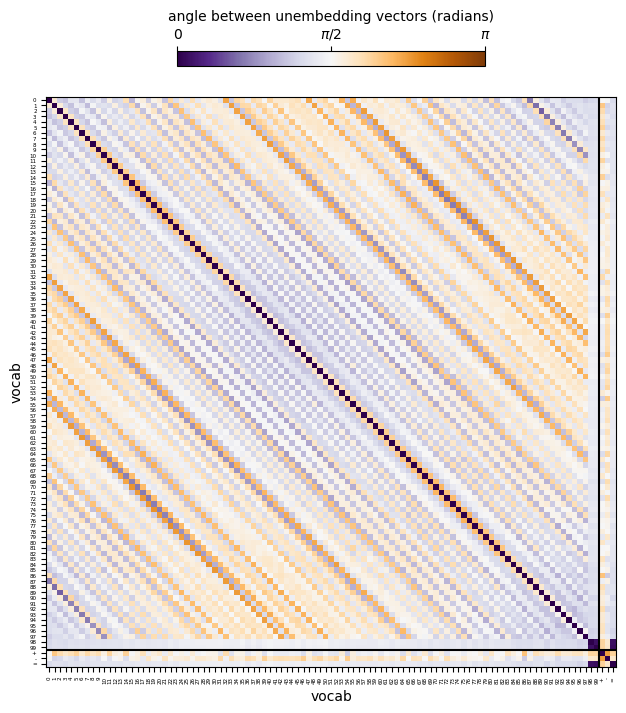

In [17]:
fig,ax = plt.subplots(1,1, figsize=(8, 8))
vocab = [s.replace(' ', '_') for s in tokenizer.convert_ids_to_tokens(range(d_vocab))]
W_U = tfm.W_U.cpu().detach().numpy()
angles = np.zeros((d_vocab,d_vocab))
for i in range(d_vocab):
    for j in range(d_vocab):
        if i == j:
            angles[i,j] = 0
        else:
            angles[i,j] = np.arccos(np.sum(W_U[:,i]*W_U[:,j])/(np.sqrt(np.sum(W_U[:,i]**2)) * np.sqrt(np.sum(W_U[:,j]**2))))
pic = ax.imshow(angles, cmap='PuOr_r', vmin=0, vmax=np.pi)
cbar = plt.colorbar(pic, orientation='horizontal', location='top', fraction=0.025)
cbar.set_label('angle between unembedding vectors (radians)')
cbar.set_ticks((0, np.pi/2, np.pi))
cbar.set_ticklabels((0, r'$\pi/2$', r'$\pi$'))
plt.ylabel('vocab')
plt.xlabel('vocab')
plt.axhline(99.5, c='k')
plt.axvline(99.5, c='k')
ax.set_yticks(range(d_vocab));
ax.set_xticks(range(d_vocab));
ax.set_xticklabels(vocab, rotation='vertical', fontsize=4);
ax.set_yticklabels(vocab, fontsize=4);
fig.savefig(figdir/'unembedding_angles.png', dpi=300, bbox_inches='tight')

# Important matrices

In [168]:
W_logit = einops.einsum(tfm.W_out[0], tfm.W_U, "d_mlp d_model, d_model d_vocab -> d_mlp d_vocab")
W_neur = einops.einsum(W_E, W_V, W_O, W_in, "d_vocab d_model, n_head d_model d_head, n_head d_head d_model, d_model d_mlp -> n_head d_vocab d_mlp")
t3 = cache['embed'][0,3,:] + cache['pos_embed'][0,3,:]
W_attn = einops.einsum(t3, W_Q, W_K, W_E, "d_model, n_head d_model d_head, n_head d_model d_head, d_vocab d_model -> n_head d_vocab") / np.sqrt(cfg.d_head)
print(W_logit.shape, W_neur.shape, W_attn.shape)

torch.Size([512, 103]) torch.Size([4, 103, 512]) torch.Size([4, 103])


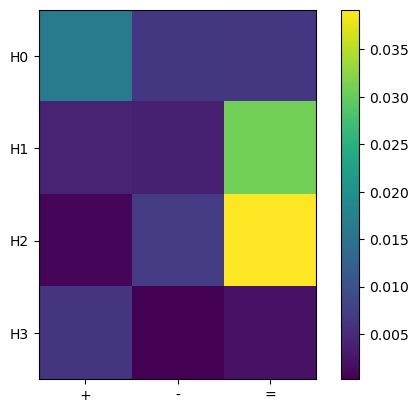

In [172]:
val = plt.imshow(np.abs(W_attn[:,-3:].detach().numpy()))
plt.xticks((0, 1, 2), labels=('+', '-', '='))
plt.yticks((0, 1, 2, 3), labels=('H0', 'H1', 'H2', 'H3'))
plt.colorbar(val)

# Logits

In [18]:
orig_logits = tfm(data.tok)
original_logits_sq = einops.rearrange(orig_logits, "(x y) seq d_vocab -> x y seq d_vocab", x=100)
log_probs_sq = original_logits_sq.log_softmax(dim=-1)
print(original_logits_sq.shape)

torch.Size([100, 100, 6, 103])


### What do the logits look like?

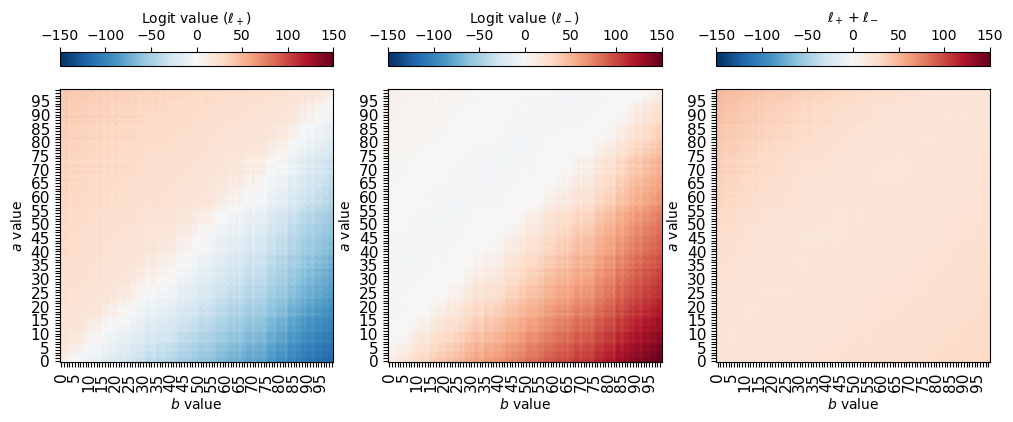

In [49]:
vmin=-150
vmax = 150
fig, axs = plt.subplots(1, 3, figsize=(12,6))
plot = axs[0].imshow(original_logits_sq[:,:,3,tokenizer.get_vocab()['+']].detach().numpy(), cmap='RdBu_r', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
cbar.set_label(r'Logit value ($\ell_+$)')
axs[0].set_ylim(-0.5, 99.5)
axs[0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
axs[0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
axs[0].set_ylabel('$a$ value')
axs[0].set_xlabel('$b$ value')

plot = axs[1].imshow(original_logits_sq[:,:,3,tokenizer.get_vocab()['-']].detach().numpy(), cmap='RdBu_r', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
cbar.set_label(r'Logit value ($\ell_-$)')
axs[1].set_ylim(-0.5, 99.5)
axs[1].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
axs[1].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
axs[1].set_ylabel('$a$ value')
axs[1].set_xlabel('$b$ value')

plot = axs[2].imshow(original_logits_sq[:,:,3,tokenizer.get_vocab()['+']].detach().numpy() + original_logits_sq[:,:,3,tokenizer.get_vocab()['-']].detach().numpy(), cmap='RdBu_r', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(plot, fraction=0.1, location='top', orientation='horizontal')
cbar.set_label(r'$\ell_+ + \ell_-$')
axs[2].set_ylim(-0.5, 99.5)
axs[2].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
axs[2].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
axs[2].set_ylabel('$a$ value')
axs[2].set_xlabel('$b$ value')

fig.savefig(figdir/'plus_minus_logits.png', dpi=300)

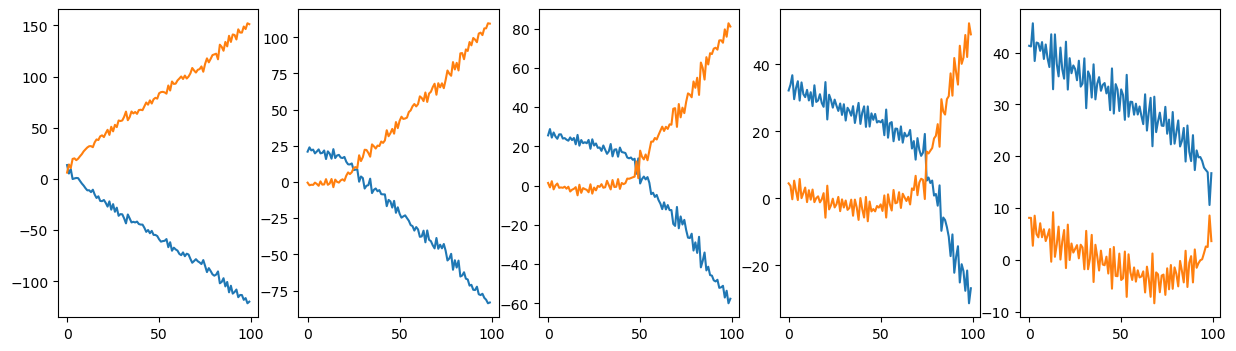

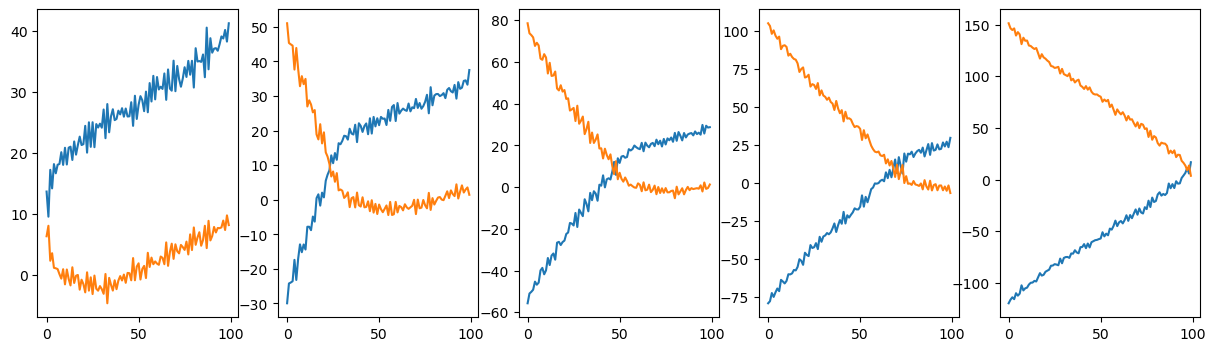

In [97]:
fig, axs = plt.subplots(1,5, figsize=(15,4))
for ax, ind in zip(axs, [0,24,49,74,99]):
    ax.plot(range(100), original_logits_sq[ind,:,3,tokenizer.get_vocab()['+']].detach().numpy(), label='+')
    ax.plot(range(100), original_logits_sq[ind,:,3,tokenizer.get_vocab()['-']].detach().numpy(), label='-')

fig, axs = plt.subplots(1,5, figsize=(15,4))
for ax, ind in zip(axs, [0,24,49,74,99]):
    ax.plot(range(100), original_logits_sq[:,ind,3,tokenizer.get_vocab()['+']].detach().numpy(), label='+')
    ax.plot(range(100), original_logits_sq[:,ind,3,tokenizer.get_vocab()['-']].detach().numpy(), label='-')

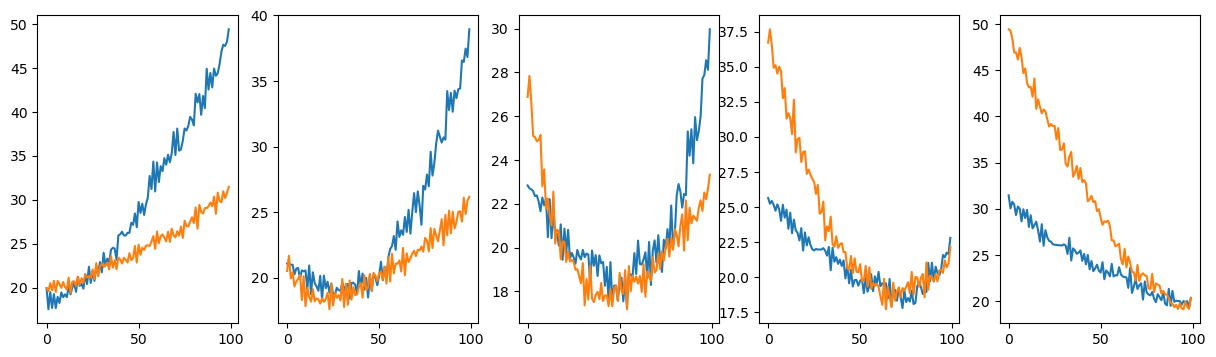

In [100]:
fig, axs = plt.subplots(1,5, figsize=(15,4))
for ax, ind in zip(axs, [0,24,49,74,99]):
    ax.plot(range(100), original_logits_sq[:,ind,3,tokenizer.get_vocab()['+']].detach().numpy() + original_logits_sq[:,ind,3,tokenizer.get_vocab()['-']].detach().numpy(), label='+')
    ax.plot(range(100), original_logits_sq[ind,:,3,tokenizer.get_vocab()['+']].detach().numpy() + original_logits_sq[ind,:,3,tokenizer.get_vocab()['-']].detach().numpy(), label='+')

# Neuron Activations

In [50]:
attn_mat = cache['pattern', 0, 'attn'][:,:,-3,:]
neuron_acts_pre = cache['blocks.0.mlp.hook_pre'][:,-3]
neuron_acts_post = cache['blocks.0.mlp.hook_post'][:,-3]
print(neuron_acts_post.shape)
neuron_acts_post_sq = einops.rearrange(neuron_acts_post, "(x y) d_mlp -> x y d_mlp", x=100)
neuron_acts_pre_sq = einops.rearrange(neuron_acts_pre, "(x y) d_mlp -> x y d_mlp", x=100)

posmask = data.tok[:,-2] == 100
negmask = data.tok[:,-2] == 101

posmask_sq = einops.rearrange(posmask.numpy(), "(x y) -> x y ", x=100)[:,:,None,None]
negmask_sq = einops.rearrange(negmask.numpy(), "(x y) -> x y ", x=100)[:,:,None,None]
print(posmask_sq.shape, posmask.sum(), negmask.sum())

torch.Size([10000, 512])
(100, 100, 1, 1) tensor(5050) tensor(4950)


In [75]:
def plot_neuronact(pos: int):
    clear_output()
    data = neuron_acts_pre_sq.detach().numpy()[:,:,pos]
    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real
    freqs = np.fft.fftfreq(100)

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    minmax = np.abs(data).max()
    plot = axs[0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0].set_ylim(-0.5, 99.5)
    axs[0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[0].set_xlabel(r'$b$ value')
    axs[0].set_ylabel(r'$a$ value')
    
    plot = axs[1].imshow(np.log10(power), cmap='magma', vmin=0)#, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} log10 power'.format(pos))
    axs[1].set_ylim(-0.5, 99.5)
    axs[1].set_yticks(range(100));
    axs[1].set_yticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10);
    axs[1].set_xticks(range(100));
    axs[1].set_xticklabels([f'{freq:.2f}' if (freq*100 % 5 == 0) else '' for freq in freqs], fontsize=10, rotation='vertical');
    axs[1].set_xlabel(r'$b$ frequency')
    axs[1].set_ylabel(r'$a$ frequency')
    
interact(plot_neuronact, pos=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact(pos: int)>

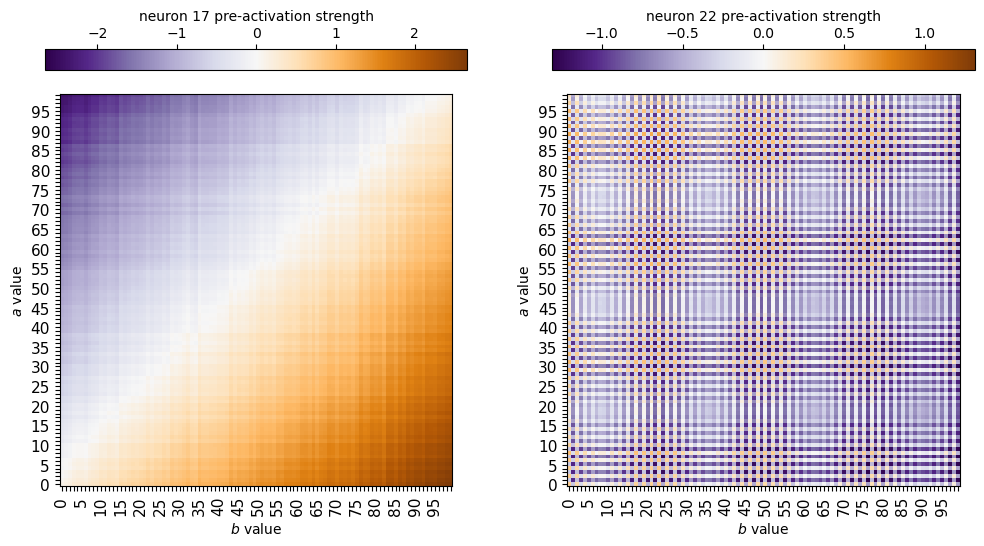

In [126]:
#plot sample neurons

fig, axs = plt.subplots(1, 2, figsize=(12,6))

neurons = [17, 22]
for i, n in enumerate(neurons):
    neur = neuron_acts_pre_sq.detach().numpy()[:,:,n]
    minmax = np.abs(neur).max()
    plot = axs[i].imshow(neur, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} pre-activation strength'.format(n))
    axs[i].set_ylim(-0.5, 99.5)
    axs[i].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[i].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[i].set_xlabel(r'$b$ value')
    axs[i].set_ylabel(r'$a$ value')

fig.savefig(figdir/'sample_neurons.png', dpi=300)

### Fit a simple linear trend to each neuron

Many neurons demonstrate a linear gradient from where $a >> b$ to where $b >> a$. Probably in terms of $a-$ and $b-$ space, this can be described in terms of a linear function $P(a,b) = c_1 (a-b) + c_3)$. Let's fit that function to each neuron and look at the fits.

In [92]:
def linfit(ab, c1, c2):
    a, b = ab
    return (c1*(a-b) + c2).ravel()

#start with neuron 17 -- it's a nice example.
neuron_17 =  neuron_acts_pre_sq.detach().numpy()[:,:,17]
avals = np.arange(100, dtype=float)
bvals = np.arange(100, dtype=float)
bb, aa = np.meshgrid(bvals, avals)


guess = (1., 0.)
popt, pcov = curve_fit(linfit, (aa,bb), neuron_17.ravel())#, p0=guess)
print(popt, pcov)

[-0.02408113  0.12580196] [[ 2.75174194e-10 -1.87338755e-17]
 [-1.87338755e-17  4.58577812e-07]]


In [97]:
def plot_neuronact_fit(pos: int):
    clear_output()
    data = neuron_acts_pre_sq.detach().numpy()[:,:,pos]

    guess = (1., 0.)
    popt, pcov = curve_fit(linfit, (aa,bb), data.ravel())

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    minmax = np.abs(data).max()
    plot = axs[0].imshow(data, cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'neuron {} activation strength'.format(pos))
    axs[0].set_ylim(-0.5, 99.5)
    axs[0].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[0].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[0].set_xlabel(r'$b$ value')
    axs[0].set_ylabel(r'$a$ value')
    
    plot = axs[1].imshow(linfit((aa,bb), *popt).reshape(100,100), cmap='PuOr_r', vmin=-minmax, vmax=minmax)
    cbar = plt.colorbar(plot, fraction=0.1, orientation='horizontal', location='top')
    cbar.set_label(r'fit with $c_1=${:.5f} and $c_2=${:.5f}'.format(*popt))
    axs[1].set_ylim(-0.5, 99.5)
    axs[1].set_yticks(range(100));
    axs[1].set_yticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11);
    axs[1].set_xticks(range(100), labels=[i if i % 5 == 0 else '' for i in range(100)], size=11, rotation='vertical');
    axs[1].set_xlabel(r'$b$ value')
    axs[1].set_ylabel(r'$a$ value')
    
interact(plot_neuronact_fit, pos=widgets.IntText(value=0, description='Index:'))

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact_fit(pos: int)>

### Fit each neuron and filter between those with a strong linear feature and those without.

In [99]:
fits = np.zeros((neuron_acts_pre_sq.shape[-1],2))
for i in range(fits.shape[0]):
    guess = (0.1, 0.)
    popt, pcov = curve_fit(linfit, (aa,bb), neuron_acts_pre_sq.detach().numpy()[:,:,i].ravel())
    fits[i,:] = popt

[[ 1.13730715e-02  4.54505450e-01]
 [ 1.88210528e-04 -5.80857715e-01]
 [ 3.04601267e-04 -3.53424521e-01]
 ...
 [-2.25638691e-02  2.06334260e-01]
 [ 4.72276318e-04 -6.12637441e-01]
 [ 2.89070069e-04 -5.54710068e-01]]


In [121]:
cutoff = 1e-3
important_neurons = np.where(np.abs(fits[:,0]) >= cutoff)[0]
unimportant_neurons = np.where(np.abs(fits[:,0]) < cutoff)[0]
print(important_neurons, len(important_neurons))

[  0   4   5   6   7   9  10  12  13  16  17  18  19  22  24  26  30  31
  32  33  35  36  38  40  42  44  46  50  52  53  55  57  59  60  61  62
  64  65  66  68  69  70  72  77  78  79  83  86  87  88  94  95  97  98
  99 101 102 103 105 106 107 108 109 110 112 113 114 116 117 118 119 124
 131 132 133 135 137 138 139 140 141 142 145 146 148 149 150 152 154 155
 157 158 159 161 162 164 166 172 177 178 180 181 184 185 189 190 195 196
 198 200 202 203 205 207 209 210 212 213 215 217 219 221 222 223 227 228
 229 230 232 234 238 242 243 244 245 251 253 254 255 257 258 259 261 262
 266 272 273 274 278 283 284 286 287 288 289 292 293 294 295 296 297 298
 299 304 305 308 309 312 314 315 316 317 319 321 322 323 325 326 327 330
 332 334 335 337 339 340 345 347 348 349 353 354 356 357 358 360 369 370
 372 373 375 376 377 379 380 383 386 388 392 393 394 396 403 405 406 408
 412 413 416 420 421 423 426 429 430 431 432 433 434 438 440 441 442 443
 444 445 446 447 450 451 452 455 457 459 460 463 46

In [122]:
# ablate unimportant neurons
def ablate_unimportant_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    neurons[:,:,unimportant_neurons] = 0

ablate_freqs = functools.partial(ablate_unimportant_neurons)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_post"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating unimportant')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating unimportant
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06878731 1.2707916 ], Ablated acc: [98.53 59.91]%


In [123]:
# ablate important neurons
def ablate_important_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    neurons[:,:,important_neurons] = 0

ablate_freqs = functools.partial(ablate_important_neurons)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_post"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating important')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating important
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [3.7850626 4.62507  ], Ablated acc: [12.710001 23.46    ]%


In [131]:
# replace important neurons
def replace_neurons(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    neurons[:,:,unimportant_neurons] = 0
    for ind in important_neurons:
        neurons[:,3,ind] = t.Tensor(linfit((aa,bb), fits[ind,0], fits[ind,1]))

ablate_freqs = functools.partial(replace_neurons)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('replacing neurons')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

replacing neurons
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.08272126 1.2707916 ], Ablated acc: [97.829994 59.91    ]%


In [26]:
#Now just plot important ones
W_logit = einops.einsum(tfm.W_out[0], tfm.W_U, "d_mlp d_model, d_model d_vocab -> d_mlp d_vocab")
def plot_neuronact(pos: int):
    clear_output()
    
    # data = neuron_acts_pre_sq.detach().numpy()[:,:,important_neurons[pos]]
    data = neuron_acts_pre_sq.detach().numpy()[:,:,important_neurons[pos]]
    ft2d = np.fft.fft2(data)
    power = (ft2d*np.conj(ft2d)).real

    logit_stuff = W_logit[important_neurons[pos], :]
    plus_logit_mul = logit_stuff[tokenizer.get_vocab()['+']]
    minus_logit_mul = logit_stuff[tokenizer.get_vocab()['-']]
    print(f'plus logit: {plus_logit_mul:.3f}, minus_logit: {minus_logit_mul:.3f}')

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    plot = axs[0].imshow(data, cmap='magma')#, vmin=0)#, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'neuron activation strength {}'.format(important_neurons[pos]))
    axs[0].set_ylim(-0.5, 99.5)
    axs[0].set_yticks(range(100), labels=range(100), size=5.5);
    axs[0].set_xticks(range(100), labels=range(100), size=5.5, rotation='vertical');
    
    plot = axs[1].imshow(np.log10(power), cmap='magma', vmin=0)#, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'neuron log10 power {}'.format(important_neurons[pos]))
    axs[1].set_ylim(-0.5, 99.5)
    axs[1].set_yticks(range(100));
    axs[1].set_yticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5);
    axs[1].set_xticks(range(100));
    axs[1].set_xticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5, rotation='vertical');
    
interact(plot_neuronact, pos=widgets.IntText(value=0, description='Index:'))
#seems like there are a few regular triangular patterns.
#Each of these activations is multiplied by a constant value from W_logit (d_mlp, d_vocab) and summed to get proper logit value for +/-
#TODO: get rid of the ones that are always active.

interactive(children=(IntText(value=0, description='Index:'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot_neuronact(pos: int)>

ok, very cool. So neuron activations linearly increase (or decrease) from upper left to bottom right on the above plot, aka from a >> b to b >> a in the parameter space. This has some bias so that ReLU() knocks out some portion of parameter space (e.g., all negatives or all positives), and then these get added together to e.g., boost '-' in the bottom right corner (and get rid of '+' there)

Pre-activation (relu) the power spectrum is just like t is coming out of the attention head (makes sense) -- big spread from low freq. The relu then step-function zeros a bunch of stuff, and that sprays stuff to higher frequency.

# Attention Patterns

In [160]:
prob = np.random.randint(0, int(1e4))
toks = data.tok[prob]
tokens = tfm.to_str_tokens(toks)

attn_patt = cache['pattern', 0, 'attn'][prob]

html = cv.attention.attention_patterns(
    tokens=tokens,
    attention=attn_patt,
)

display(html)

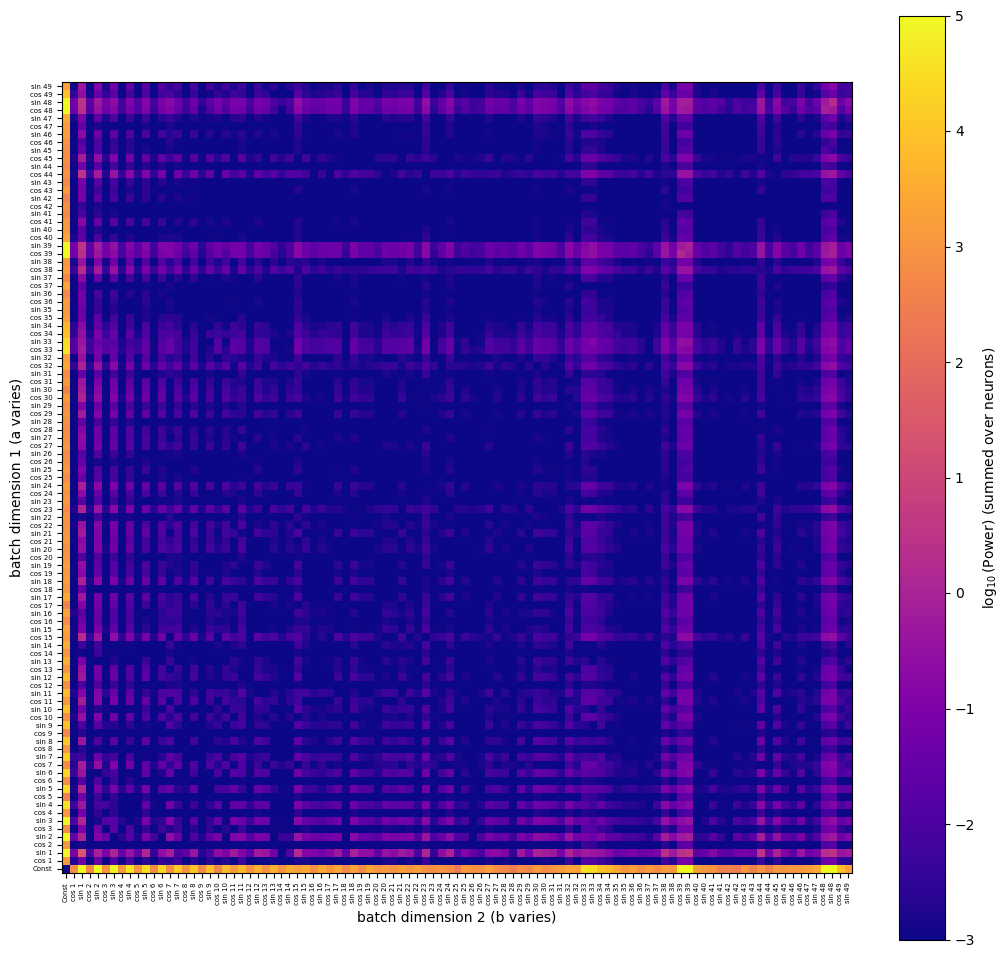

In [26]:
neuron_acts_centered = neuron_acts_post_sq - neuron_acts_post_sq.mean((0,1),keepdim=True)
# neuron_acts_centered = neuron_acts_pre_sq - neuron_acts_pre_sq.mean((0,1),keepdim=True)
ft_acts = fft2d(neuron_acts_centered)


kfreqs = t.Tensor([ 1, 33, 39, 48]).to(t.int)


square_of_all_terms = einops.reduce(
        ft_acts.pow(2),
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )
square_of_all_terms[square_of_all_terms < 1e-16] = 1e-16

power = (ft_acts**2).sum(axis=-1)

# power = (ft_acts**2/square_of_all_terms[None,None,:]).sum(axis=-1)

# print(f'power before {power.sum():.3e}')
# power[0,:] = 1e-8
# power[:,0] = 1e-8
# print(f'power after like-terms {power.sum():.3e}')
# for f in kfreqs:
#     power[2*f-1,:] = 1e-8
#     power[2*f,:] = 1e-8
#     power[:,2*f-1] = 1e-8
#     power[:,2*f] = 1e-8
# print(f'power after {power.sum():.3e}')
# print(1.058e6/3.438e6)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
axs = [ax,]
plot = axs[0].imshow(np.log10(power[:-1,:-1]), cmap='plasma', vmin=-3, vmax=5)
cbar = plt.colorbar(plot, fraction=0.1)
cbar.set_label(r'$\log_{10}(\rm{Power})$ (summed over neurons)')
axs[0].set_ylim(-0.5, 98.5)
axs[0].set_yticks(range(99));
axs[0].set_yticklabels(fourier_basis_names, fontsize=5);
axs[0].set_xticks(range(99));
axs[0].set_xticklabels(fourier_basis_names, fontsize=5, rotation='vertical');
axs[0].set_ylabel('batch dimension 1 (a varies)')
axs[0].set_xlabel('batch dimension 2 (b varies)')
fig.savefig(figdir/'neuron_post_power_sum.png', dpi=300)

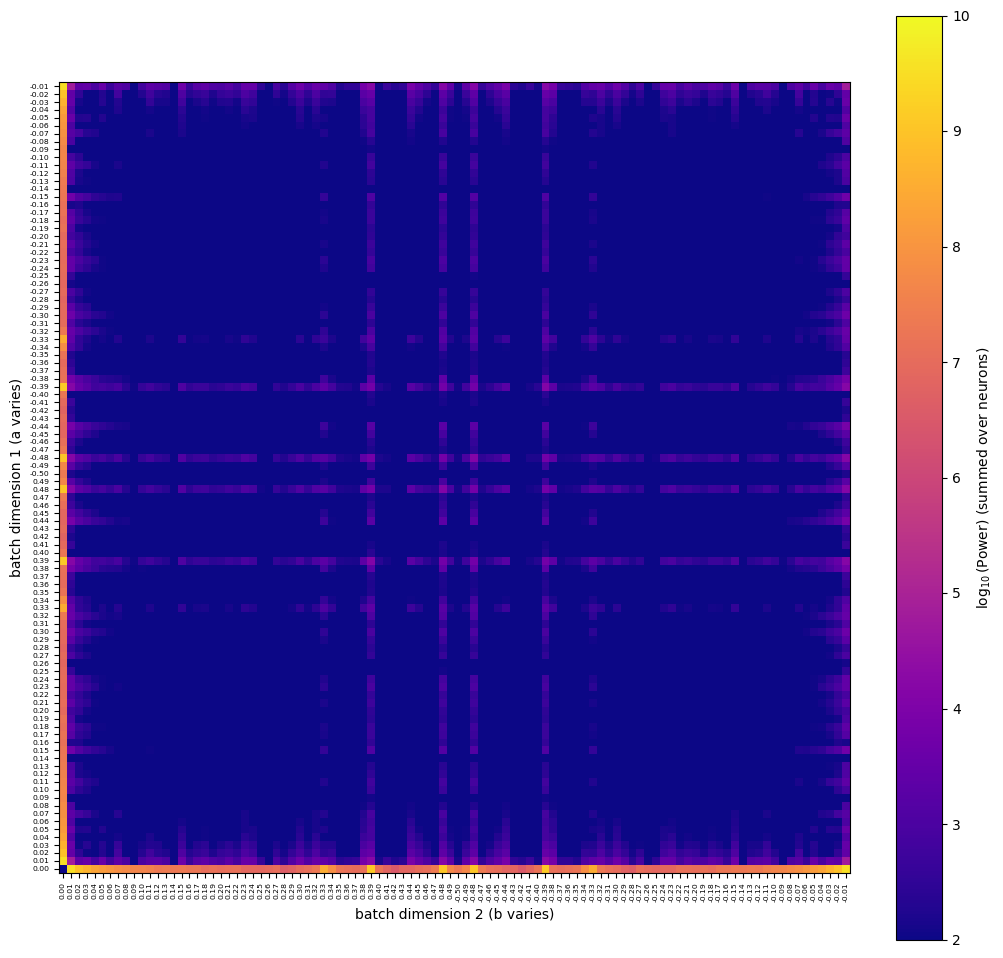

In [27]:
mask = posmask_sq[:,:,:,0]
mask = negmask_sq[:,:,:,0]
mask = 1

neuron_acts_centered = neuron_acts_post_sq - neuron_acts_post_sq.mean((0,1),keepdim=True)
ft_acts = np.fft.fft2(mask*neuron_acts_centered.detach().numpy(), axes=[0,1])
# print('constant term: {}'.format(ft_acts[0,0]))


kfreqs = t.Tensor([ 1, 33, 39, 48]).to(t.int)


square_of_all_terms = einops.reduce(
        np.conj(ft_acts)*ft_acts,
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )
square_of_all_terms[square_of_all_terms < 1e-16] = 1e-16

power = (np.conj(ft_acts)*ft_acts).real.sum(axis=-1)
phase = ft_acts.imag / ft_acts.real
# print(phase)

# power = (ft_acts**2/square_of_all_terms[None,None,:]).sum(axis=-1)

# print(f'power before {power.sum():.3e}')
# power[0,:] = 1e-8
# power[:,0] = 1e-8
# print(f'power after like-terms {power.sum():.3e}')
# for f in kfreqs:
#     power[2*f-1,:] = 1e-8
#     power[2*f,:] = 1e-8
#     power[:,2*f-1] = 1e-8
#     power[:,2*f] = 1e-8
# print(f'power after {power.sum():.3e}')
# print(1.058e6/3.438e6)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
axs = [ax,]
plot = axs[0].imshow(np.log10(power), cmap='plasma', vmin=2, vmax=10)
cbar = plt.colorbar(plot, fraction=0.1)
cbar.set_label(r'$\log_{10}(\rm{Power})$ (summed over neurons)')
axs[0].set_ylim(-0.5, 99.5)
axs[0].set_yticks(range(100));
axs[0].set_yticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5);
axs[0].set_xticks(range(100));
axs[0].set_xticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5, rotation='vertical');
axs[0].set_ylabel('batch dimension 1 (a varies)')
axs[0].set_xlabel('batch dimension 2 (b varies)')
fig.savefig(figdir/'neuron_post_power_sum.png', dpi=300)

[ 0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49 -0.5  -0.49 -0.48 -0.47 -0.46 -0.45 -0.44 -0.43 -0.42 -0.41
 -0.4  -0.39 -0.38 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29
 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17
 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05
 -0.04 -0.03 -0.02 -0.01]


/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27482/2433685052.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(freqs, 6e4*(0.01/freqs)**1, c='orange', lw=0.5)


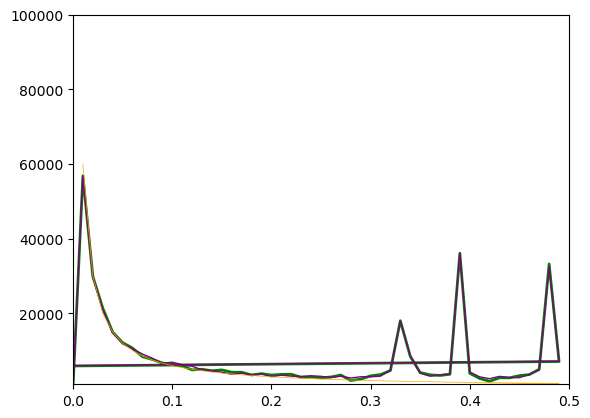

In [28]:
# The terms have amplitude like 1/f.
plt.plot(freqs, np.sqrt(power[0,:]), c='green', lw=2)
plt.plot(freqs, np.sqrt(power[:,0]), c='purple', lw=1)
plt.ylim(1e3, 1e5)
plt.xlim(0, 0.5)
print(freqs)
x = np.linspace(0.01, 0.5, 100)
plt.plot(freqs, 6e4*(0.01/freqs)**1, c='orange', lw=0.5)

In [29]:
def arrange_by_2d_freqs(tensor):
    '''
    Takes a tensor of shape (p, p, ...) and returns a tensor of shape
    (p//2 - 1, 3, 3, ...) representing the Fourier coefficients sorted by
    frequency (each slice contains const, linear and quadratic terms).

    In other words, if the first two dimensions of the original tensor
    correspond to indexing by 2D Fourier frequencies as follows:

        1           cos(w_1*x)            sin(w_1*x)           ...
        cos(w_1*y)  cos(w_1*x)cos(w_1*y)  sin(w_1*x)cos(w_1*y) ...
        sin(w_1*y)  cos(w_1*x)sin(w_1*y)  sin(w_1*x)sin(w_1*y) ...
        cos(w_2*y)  cos(w_1*x)cos(w_2*y)  sin(w_1*x)cos(w_2*y) ...
        ...

    Then the (k-1)-th slice of the new tensor are the terms corresponding to
    the following 2D Fourier frequencies:

        1           cos(w_k*x)            sin(w_k*x)           ...
        cos(w_k*y)  cos(w_k*x)cos(w_k*y)  sin(w_k*x)cos(w_k*y) ...
        sin(w_k*y)  cos(w_k*x)sin(w_k*y)  sin(w_k*x)sin(w_k*y) ...

    for k = 1, 2, ..., p//2.

    Note we omit the constant term, i.e. the 0th slice has frequency k=1.
    '''
    idx_2d_y_all = []
    idx_2d_x_all = []
    for freq in range(1, 100//2):
        idx_1d = [0, 2*freq-1, 2*freq]
        idx_2d_x_all.append([idx_1d for _ in range(3)])
        idx_2d_y_all.append([[i]*3 for i in idx_1d])
    # print(idx_2d_x_all)
    return tensor[idx_2d_y_all, idx_2d_x_all]


def find_neuron_freqs(
    fourier_neuron_acts: Float[Tensor, "p p d_mlp"],
    top_k : int = 1
) -> Tuple[Float[Tensor, "d_mlp"], Float[Tensor, "d_mlp"]]:
    '''
    Returns the tensors `neuron_freqs` and `neuron_frac_explained`,
    containing the frequencies that explain the most variance of each
    neuron and the fraction of variance explained, respectively.
    '''
    fourier_neuron_acts_by_freq = arrange_by_2d_freqs(fourier_neuron_acts)
    assert fourier_neuron_acts_by_freq.shape == (100//2-1, 3, 3, d_mlp)

    # Sum squares of all frequency coeffs, for each neuron
    square_of_all_terms = einops.reduce(
        fourier_neuron_acts.pow(2),
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )

    # Sum squares just corresponding to const+linear+quadratic terms,
    # for each frequency, for each neuron
    square_of_each_freq = einops.reduce(
        fourier_neuron_acts_by_freq.pow(2),
        "freq x_coeff y_coeff neuron -> freq neuron",
        "sum"
    )

    if top_k == 1:
        # Find the freq explaining most variance for each neuron
        # (and the fraction of variance explained)
        neuron_variance_explained, neuron_freqs = square_of_each_freq.max(0)
        neuron_frac_explained = neuron_variance_explained / square_of_all_terms
    
        # The actual frequencies count up from k=1, not 0!
        neuron_freqs += 1
        return neuron_freqs, neuron_frac_explained
    else:
        # Find the freq explaining most variance for each neuron
        # (and the fraction of variance explained)
        neuron_variance_explained, neuron_freqs = square_of_each_freq.topk(top_k,dim=0)
        neuron_frac_explained = neuron_variance_explained.sum(dim=0) / square_of_all_terms
    
        # The actual frequencies count up from k=1, not 0!
        neuron_freqs += 1
        return neuron_freqs, neuron_frac_explained
        
        

neuron_freqs, neuron_frac_explained = find_neuron_freqs(t.Tensor(ft_acts), top_k=1)
key_freqs, neuron_freq_counts = t.unique(t.sort(neuron_freqs).values, return_counts=True)#, dim=1)

print('key frequencies: ', key_freqs)

key frequencies:  tensor([17, 20, 24, 25, 26, 31, 34, 43])


/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27482/3944461795.py:85: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1699325338999/work/aten/src/ATen/native/Copy.cpp:299.)
  neuron_freqs, neuron_frac_explained = find_neuron_freqs(t.Tensor(ft_acts), top_k=1)


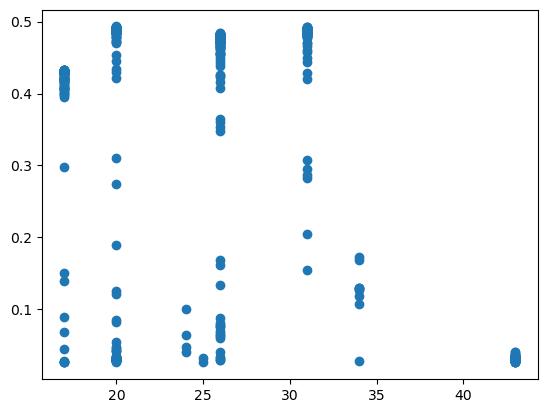

In [30]:
plt.scatter(neuron_freqs, neuron_frac_explained)

Only up to half of the power is contained in these 'like' terms (w_k with w_k). Turns out this half of the power is entirely in terms like cos(w_k) or sin(w_k). 

What happens if, for each neuron, we sample all the power in all the terms of its maximum frequency -- what happens then?

Text(0, 0.5, 'fraction of neuron power in dominant frequency')

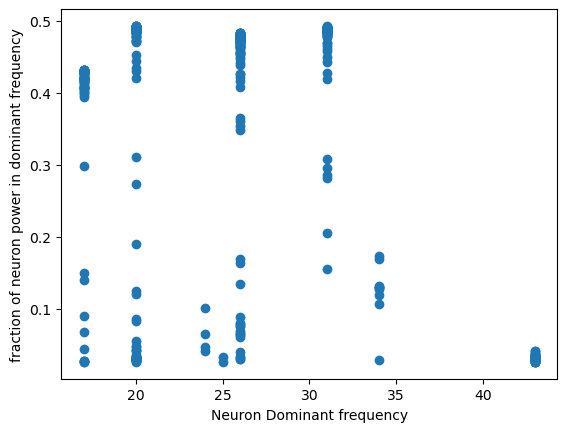

In [31]:
def check_neuron_power(
    fourier_neuron_acts: Float[Tensor, "p p d_mlp"],
    neuron_freqs: Int[Tensor, "d_mlp"],
) -> Tuple[Float[Tensor, "d_mlp"], Float[Tensor, "d_mlp"]]:
    # Sum squares of all frequency coeffs, for each neuron
    square_of_all_terms = einops.reduce(
        fourier_neuron_acts.pow(2),
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )
    pow = fourier_neuron_acts.pow(2)

    neuron_pow = t.zeros(neuron_freqs.shape[0])
    for i,f in enumerate(neuron_freqs):
        for j in (2*f-1, 2*f):
            neuron_pow[i] += pow[j,:,i].sum()
            neuron_pow[i] += pow[:,j,i].sum()
            for k in (2*f-1, 2*f):
                neuron_pow[i] -= pow[j,k,i] #fix the four places where the rows/columns overlap

    return neuron_pow / square_of_all_terms
frac_explained = check_neuron_power(t.Tensor(ft_acts), neuron_freqs)

plt.scatter(neuron_freqs, frac_explained)
plt.xlabel("Neuron Dominant frequency")
plt.ylabel("fraction of neuron power in dominant frequency")

### Ablate unimportant frequencies for each head
Now we're going to write a hook to fourier transform the data, remove all frequencies except the most important one for each head, then transform back into 

In [32]:
freqs = np.fft.fftfreq(100)
key_freq_inds = []
for f1 in key_freqs:
    for i, f2 in enumerate(freqs):
        if np.abs(f2) == f1/100:
            key_freq_inds.append(i)
# neuron_freq_inds = t.Tensor([[i for i, f1 in enumerate(freqs) if np.abs(f1) == f2/100] for f2 in neuron_freqs]).to(t.int)
print(key_freq_inds)

[17, 83, 20, 80, 24, 76, 25, 75, 26, 74, 31, 69, 34, 66, 43, 57]


In [33]:
def crossfreq_ablation_hook(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint,
    seq_ind: int = -2
) -> Float[Tensor, "batch seq d_mlp"]:
    
    neuron_acts_post_sq = einops.rearrange(neurons[:,seq_ind,:], "(x y) d_mlp -> x y d_mlp", x=100)
    ft = np.fft.fft2(neuron_acts_post_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    N = 50
    new_ft[0,:N,:] = ft[0,:N,:]
    new_ft[:N,0,:] = ft[:N,0,:]
    new_ft[0,-N+1:,:] = ft[0,-N+1:,:]
    new_ft[-N+1:,0,:] = ft[-N+1:,0,:]
    # for k in key_freq_inds:
    #     new_ft[0,k,:] = ft[0,k,:]
    #     new_ft[k,0,:] = ft[k,0,:]
    acts = np.fft.ifft2(new_ft, axes=[0,1]).real
    neuron_acts_post_sq[:] = t.Tensor(acts)
    neurons[:,seq_ind,:] = einops.rearrange(neuron_acts_post_sq, "x y d_mlp -> (x y) d_mlp")


ablate_freqs = functools.partial(crossfreq_ablation_hook, seq_ind=-3)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -3')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_freqs = functools.partial(crossfreq_ablation_hook, seq_ind=-2)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -2')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")


Ablating seq_ind -3
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07938547 0.01807367], Ablated acc: [98.409996 99.94    ]%
Ablating seq_ind -2
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 5.2879076 ], Ablated acc: [98.549995 15.83    ]%


In [34]:
def simplefreq_ablation_hook(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint,
    seq_ind: int = -2
) -> Float[Tensor, "batch seq d_mlp"]:
    
    neuron_acts_post_sq = einops.rearrange(neurons[:,seq_ind,:], "(x y) d_mlp -> x y d_mlp", x=100)
    ft = np.fft.fft2(neuron_acts_post_sq.detach().numpy(), axes=[0,1])
    ft[0,:,:] = 0
    ft[:,0,:] = 0
    acts = np.fft.ifft2(ft, axes=[0,1]).real
    neuron_acts_post_sq[:] = t.Tensor(acts)
    neurons[:,seq_ind,:] = einops.rearrange(neuron_acts_post_sq, "x y d_mlp -> (x y) d_mlp")


ablate_freqs = functools.partial(simplefreq_ablation_hook, seq_ind=-3)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -3')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_freqs = functools.partial(simplefreq_ablation_hook, seq_ind=-2)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -2')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")


Ablating seq_ind -3
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [3.2895625  0.01807367], Ablated acc: [85.32 99.94]%
Ablating seq_ind -2
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 0.06826339 10.379588  ], Ablated acc: [98.549995  1.48    ]%


# Residual stream spots

## After Embedding

In [35]:
print(cache)
resid_pre = cache['resid_pre', 0]
resid_pre_sq = einops.rearrange(resid_pre, "(x y) seq d_model  -> x y seq d_model", x=100)

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post']


In [140]:
def plot_residual_embed(pos: int, plot_ind: int):
    clear_output()
    print(plot_ind, pos)
    data = resid_pre_sq.detach().numpy()[:,:,plot_ind,pos]
    plot = plt.imshow(data, cmap='RdBu_r')#, vmin=-1, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'residual stream position {}'.format(pos))
    
interact(plot_residual_embed, pos=widgets.IntText(value=50, description='Index:'), plot_ind=widgets.IntText(value=0, description='Seq_pos:'))

interactive(children=(IntText(value=50, description='Index:'), IntText(value=0, description='Seq_pos:'), Outpu…

<function __main__.plot_residual_embed(pos: int, plot_ind: int)>

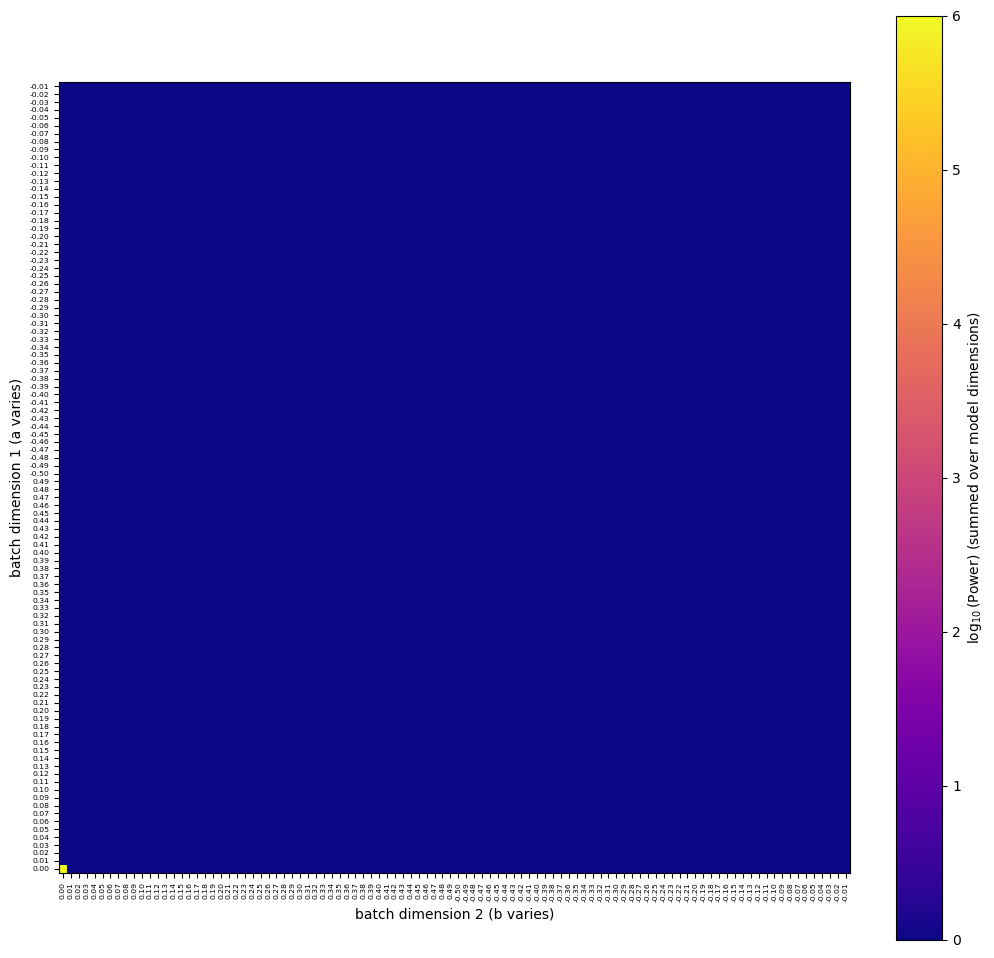

In [101]:
mask = 1

ft_resid = np.fft.fft2(mask*resid_pre_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid).sum(axis=-1).real
power[power == 0] = 1e-16
resid_pre_power = power
resid_pre_ft = ft_resid

plot_ind = 3


fig, ax = plt.subplots(1, 1, figsize=(12,12))
axs = [ax,]
plot = axs[0].imshow(np.log10(power)[:,:,plot_ind], cmap='plasma', vmin=0, vmax=6)
cbar = plt.colorbar(plot, fraction=0.1)
cbar.set_label(r'$\log_{10}(\rm{Power})$ (summed over model dimensions)')
axs[0].set_ylim(-0.5, 99.5)
axs[0].set_yticks(range(100));
axs[0].set_yticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5);
axs[0].set_xticks(range(100));
axs[0].set_xticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5, rotation='vertical');
axs[0].set_ylabel('batch dimension 1 (a varies)')
axs[0].set_xlabel('batch dimension 2 (b varies)')
fig.savefig(figdir/'neuron_post_power_sum.png', dpi=300)

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27482/475202280.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.5)
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27482/475202280.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(freqs[freqs >= 0], 2.5e3*(0.01/freqs[freqs >= 0])**1, c='orange', lw=1)


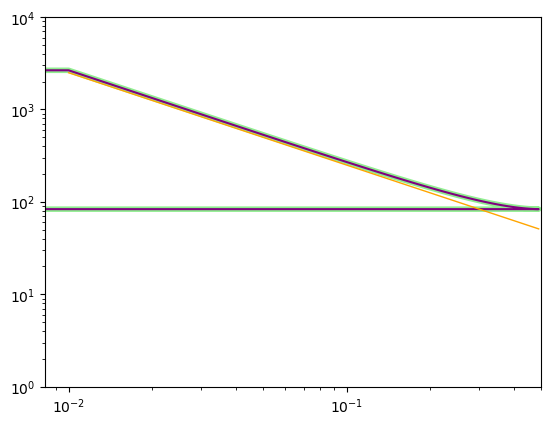

In [37]:
# The terms have amplitude like 1/f.
plt.loglog(freqs, np.sqrt(power[0,:,plot_ind]), c='lightgreen', lw=4)
plt.plot(freqs, np.sqrt(power[:,0,plot_ind]), c='purple', lw=1.5)
plt.ylim(1e0, 1e4)
plt.xlim(0, 0.5)
x = np.linspace(0.01, 0.5, 100)
plt.plot(freqs[freqs >= 0], 2.5e3*(0.01/freqs[freqs >= 0])**1, c='orange', lw=1)

In [38]:
def freq2d_ablation_hook(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    
    residual_sq = einops.rearrange(residual[:,:], "(x y) seq d_mlp -> x y seq d_mlp", x=100)
    ft = np.fft.fft2(residual_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    new_ft[0,:,:] = ft[0,:,:]
    new_ft[:,0,:] = ft[:,0,:]
    residual_sq = np.fft.ifft2(new_ft, axes=[0,1]).real
    residual_sq = t.Tensor(residual_sq)
    residual[:] = einops.rearrange(residual_sq, "x y seq d_mlp -> (x y) seq d_mlp")


ablate_freqs = functools.partial(freq2d_ablation_hook)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind 2d frequencies')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating seq_ind 2d frequencies
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826339 0.5529162 ], Ablated acc: [98.549995 88.43    ]%


## After Attention

In [149]:
def freq2d_ablation_hook(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint = None
) -> Float[Tensor, "batch seq d_mlp"]:
    
    residual_sq = einops.rearrange(residual[:,:], "(x y) seq d_mlp -> x y seq d_mlp", x=100)
    ft = np.fft.fft2(residual_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    new_ft[0,:,:] = ft[0,:,:]
    new_ft[:,0,:] = ft[:,0,:]
    residual_sq = np.fft.ifft2(new_ft, axes=[0,1]).real
    residual_sq = t.Tensor(residual_sq)
    residual[:] = einops.rearrange(residual_sq, "x y seq d_mlp -> (x y) seq d_mlp")


ablate_freqs = functools.partial(freq2d_ablation_hook)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_mid"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind 2d frequencies')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating seq_ind 2d frequencies
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07325259 5.415411  ], Ablated acc: [98.47 16.32]%


In [159]:
def residual_indices_ablation(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint = None,
    indices: list = [],
) -> Float[Tensor, "batch seq d_mlp"]:
    residual[:,:,indices] = 0


for i in range(cfg.d_model):
    func = functools.partial(residual_indices_ablation, indices=[i])
    ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                    (utils.get_act_name("blocks.0.hook_resid_mid"), func)
                ])
    ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
    ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)
    
    print('Ablating index ', i)
    print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
    print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating index  0
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07074806 0.01776248], Ablated acc: [98.42 99.94]%
Ablating index  1
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07034506 0.01789776], Ablated acc: [98.57 99.94]%
Ablating index  2
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06876414 0.01798897], Ablated acc: [98.53 99.94]%
Ablating index  3
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07065102 0.01804731], Ablated acc: [98.53 99.94]%
Ablating index  4
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07021645 0.01774055], Ablated acc: [98.549995 99.94    ]%
Ablating index  5
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07282469 0.01803744], Ablated acc: [98.369995 99.94    ]%
Ablating ind

In [162]:
func = functools.partial(residual_indices_ablation, indices=[1,2,3,4,6,9,12,13,15,17,20,22,25,26,31,32,33,37,38,40,42,44,48,49,50,51,53,54,55,57,64])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_mid"), func)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating index ', i)
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating index  127
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.286772   0.04214706], Ablated acc: [95.73 99.62]%


In [163]:
print(cache)
resid_mid = t.clone(cache['resid_mid', 0])
print(resid_mid)
freq2d_ablation_hook(resid_mid)
print(resid_mid)
resid_mid_sq = einops.rearrange(resid_mid, "(x y) seq d_model  -> x y seq d_model", x=100)

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post']
tensor([[[ 2.0846e-01, -2.6759e-01,  4.3488e-01,  ..., -5.5325e-01,
           8.2805e-01, -5.7196e-01],
         [ 1.7704e-01, -1.6425e-01,  1.2108e-01,  ..., -2.6299e-01,
           4.7974e-01, -3.6890e-01],
         [ 1.2623e-01, -1.7861e-01,  3.7314e-01,  ..., -2.8211e-01,
           6.0285e-01, -4.2995e-01],
         [-2.0184e-01, -2.1427e-01, -4.6438e-02,  ..., -3.0117e-01,
           2.5573e-01, -4.5548e-01],
         [ 2.6167e-01, -2.2386e-01,  5.3739e-01,  ..., -6.1444e-01,
           7.5856e-01, -3.0094e-01],
         [ 1.6062e-01, -1.3011e-01,  2.7030e-01,  ..., -3.3823e-01,
    

In [164]:
def plot_residual_mid(pos: int, pos2: ind, plot_ind: int):
    clear_output()
    embed = resid_pre_sq.detach().numpy()[:,:,:,pos2]
    data = resid_mid_sq.detach().numpy()[:,:,plot_ind,pos] - resid_pre_sq.detach().numpy()[:,:,plot_ind,pos]
    guess =  embed[:,:,2] - embed[:,:,0]
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    plot = axs[0].imshow(data, cmap='RdBu_r', vmin=-1, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'residual stream position {}'.format(pos))
    plot = axs[1].imshow(guess, cmap='RdBu_r', vmin=-1, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    
interact(plot_residual_mid, pos=widgets.IntText(value=50, description='Index:'), pos2=widgets.IntText(value=50, description='E Index:'),plot_ind=widgets.IntText(value=3, description='Seq_pos:'))

interactive(children=(IntText(value=50, description='Index:'), IntText(value=50, description='E Index:'), IntT…

<function __main__.plot_residual_mid(pos: int, pos2: 99, plot_ind: int)>

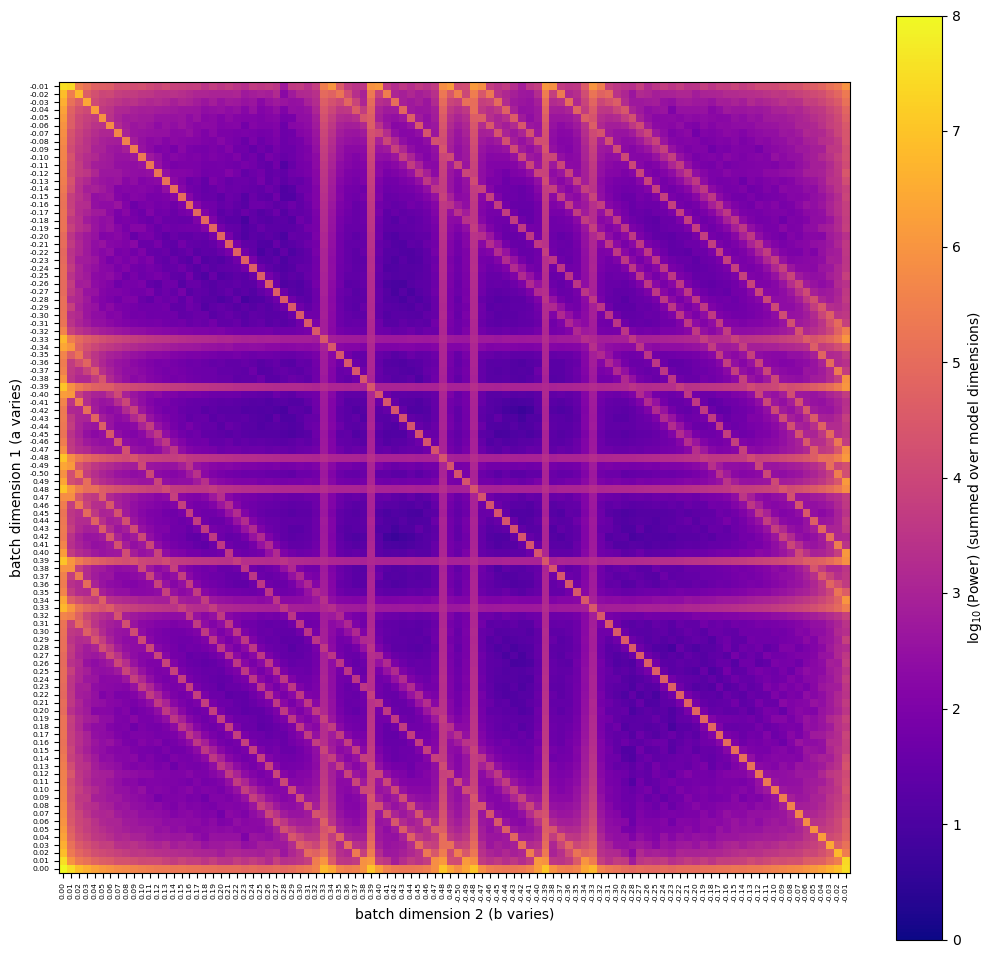

In [40]:
mask = posmask_sq

ft_resid = np.fft.fft2(mask*resid_mid_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid)[:,:,-3].sum(axis=-1).real
power[power == 0] = 1e-16


fig, ax = plt.subplots(1, 1, figsize=(12,12))
axs = [ax,]
plot = axs[0].imshow(np.log10(power), cmap='plasma', vmin=0, vmax=8)
cbar = plt.colorbar(plot, fraction=0.1)
cbar.set_label(r'$\log_{10}(\rm{Power})$ (summed over model dimensions)')
axs[0].set_ylim(-0.5, 99.5)
axs[0].set_yticks(range(100));
axs[0].set_yticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5);
axs[0].set_xticks(range(100));
axs[0].set_xticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5, rotation='vertical');
axs[0].set_ylabel('batch dimension 1 (a varies)')
axs[0].set_xlabel('batch dimension 2 (b varies)')
fig.savefig(figdir/'neuron_post_power_sum.png', dpi=300)

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27482/271181355.py:7: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.5)
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27482/271181355.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(freqs[freqs >= 0], 2.5e3*(0.01/freqs[freqs >= 0])**1, c='orange', lw=1)


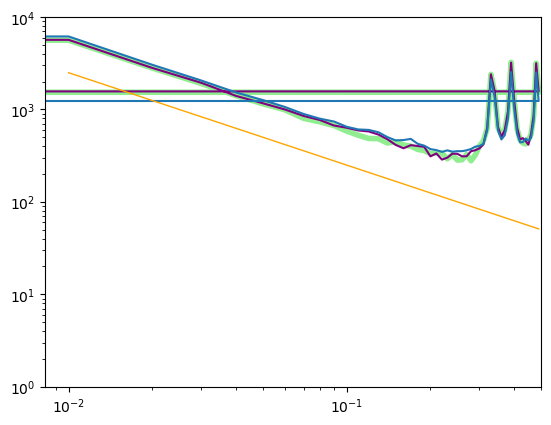

In [41]:
# The terms have amplitude like 1/f.
plt.loglog(freqs, np.sqrt(power[0,:]), c='lightgreen', lw=4)
plt.plot(freqs, np.sqrt(power[:,0]), c='purple', lw=1.5)
plt.plot(freqs, np.sqrt(4*(resid_pre_power[:,0,0] + resid_pre_power[:,0,2] + resid_pre_power[:,0,3]))) # This is what attention did.
# plt.plot(freqs, 2*np.sqrt(resid_pre_power[0,:,0] + resid_pre_power[0,:,2] + 16*resid_pre_power[0,:,3])) # This is what attention did.
plt.ylim(1e0, 1e4)
plt.xlim(0, 0.5)
x = np.linspace(0.01, 0.5, 100)
plt.plot(freqs[freqs >= 0], 2.5e3*(0.01/freqs[freqs >= 0])**1, c='orange', lw=1)

In [148]:
def freq2d_ablation_hook(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    
    residual_sq = einops.rearrange(residual[:,:], "(x y) seq d_mlp -> x y seq d_mlp", x=100)
    ft = np.fft.fft2(residual_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    new_ft[0,:,:] = ft[0,:,:]
    new_ft[:,0,:] = ft[:,0,:]
    residual_sq = np.fft.ifft2(new_ft, axes=[0,1]).real
    residual_sq = t.Tensor(residual_sq)
    residual[:] = einops.rearrange(residual_sq, "x y seq d_mlp -> (x y) seq d_mlp")


ablate_freqs = functools.partial(freq2d_ablation_hook)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_mid"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind 2d frequencies')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating seq_ind 2d frequencies
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07325259 5.415411  ], Ablated acc: [98.47 16.32]%


## After MLP

In [43]:
print(cache)
resid_post = cache['resid_post', 0]
resid_post_sq = einops.rearrange(resid_post, "(x y) seq d_model  -> x y seq d_model", x=100)

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post']


In [173]:
def plot_residual_post(pos: int, pos2: int, plot_ind: int):
    clear_output()
    data = resid_post_sq.detach().numpy()[:,:,plot_ind,pos2]
    # plot = plt.imshow(data, cmap='RdBu_r')#, vmin=-1, vmax=1)
    # cbar = plt.colorbar(plot, fraction=0.1)
    # cbar.set_label(r'residual stream position {}'.format(pos))

    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    plot = axs[0].imshow(resid_mid_sq.detach().numpy()[:,:,plot_ind,pos], cmap='RdBu_r')#, vmin=-1, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'mid residual stream position {}'.format(pos))
    plot = axs[1].imshow(data, cmap='RdBu_r')#, vmin=-1, vmax=1)
    cbar = plt.colorbar(plot, fraction=0.1)
    cbar.set_label(r'post residual stream position {}'.format(pos2))
    
interact(plot_residual_post, pos=widgets.IntText(value=50, description='Index:'), pos2=widgets.IntText(value=50, description='PostIndex:'), plot_ind=widgets.IntText(value=3, description='Seq_pos:'))

interactive(children=(IntText(value=50, description='Index:'), IntText(value=50, description='PostIndex:'), In…

<function __main__.plot_residual_post(pos: int, pos2: int, plot_ind: int)>

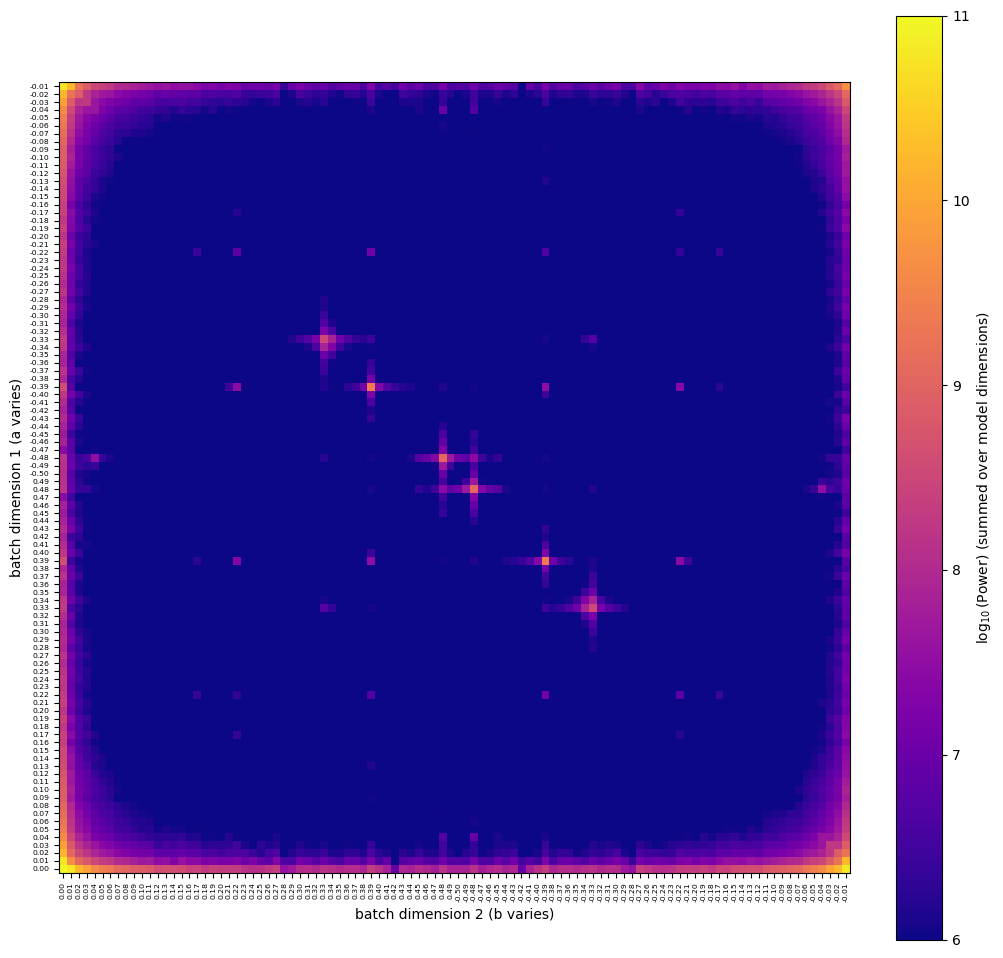

In [44]:
mask = 1

ft_resid = np.fft.fft2(mask*resid_post_sq.detach().numpy(), axes=[0,1])
power = (np.conj(ft_resid)*ft_resid)[:,:,-3].sum(axis=-1).real
power[power == 0] = 1e-16


fig, ax = plt.subplots(1, 1, figsize=(12,12))
axs = [ax,]
plot = axs[0].imshow(np.log10(power), cmap='plasma', vmin=6, vmax=11)
cbar = plt.colorbar(plot, fraction=0.1)
cbar.set_label(r'$\log_{10}(\rm{Power})$ (summed over model dimensions)')
axs[0].set_ylim(-0.5, 99.5)
axs[0].set_yticks(range(100));
axs[0].set_yticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5);
axs[0].set_xticks(range(100));
axs[0].set_xticklabels([f'{freq:.2f}' for freq in freqs], fontsize=5.5, rotation='vertical');
axs[0].set_ylabel('batch dimension 1 (a varies)')
axs[0].set_xlabel('batch dimension 2 (b varies)')
fig.savefig(figdir/'neuron_post_power_sum.png', dpi=300)

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27482/4149561642.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 0.5)
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_27482/4149561642.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(freqs[freqs >= 0], 2.5e5*(0.01/freqs[freqs >= 0])**1, c='orange', lw=1)


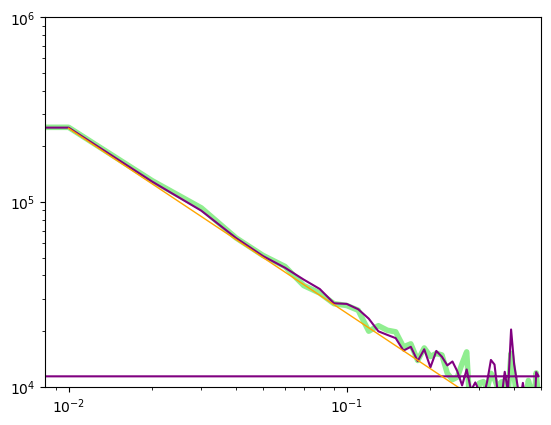

In [45]:
# The terms have amplitude like 1/f.
plt.loglog(freqs, np.sqrt(power[0,:]), c='lightgreen', lw=4)
plt.plot(freqs, np.sqrt(power[:,0]), c='purple', lw=1.5)
plt.ylim(1e4, 1e6)
plt.xlim(0, 0.5)
x = np.linspace(0.01, 0.5, 100)
plt.plot(freqs[freqs >= 0], 2.5e5*(0.01/freqs[freqs >= 0])**1, c='orange', lw=1)

In [46]:
def freq2d_ablation_hook(
    residual: Float[Tensor, "batch seq d_model"],
    hook: HookPoint
) -> Float[Tensor, "batch seq d_mlp"]:
    
    residual_sq = einops.rearrange(residual[:,:], "(x y) seq d_mlp -> x y seq d_mlp", x=100)
    ft = np.fft.fft2(residual_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    new_ft[0,:,:] = ft[0,:,:]
    new_ft[:,0,:] = ft[:,0,:]
    residual_sq = np.fft.ifft2(new_ft, axes=[0,1]).real
    residual_sq = t.Tensor(residual_sq)
    residual[:] = einops.rearrange(residual_sq, "x y seq d_mlp -> (x y) seq d_mlp")


ablate_freqs = functools.partial(freq2d_ablation_hook)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.hook_resid_post"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind 2d frequencies')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating seq_ind 2d frequencies
Original loss: [0.06826339 0.01807367], Original acc: [98.549995 99.94    ]%
Ablated loss: [2.8105764 5.347927 ], Ablated acc: [85.84  1.48]%


Frequency gets spread out in the MLP. Looks like a straight up multiplication.